# Introduction 

Name : Kevin Giovanni Pradana

Batch : FTDS-008

Project : Surface Crack Detection


Data Overview :    

* **Concrete surface cracks are major defect in civil structures. Building Inspection which is done for the evaluation of rigidity and tensile strength of the building. Crack detection plays a major role in the building inspection, finding the cracks and determining the building health.**


---
* The datasets contains images of various concrete surfaces with and without crack. 
* The image data are divided into two as negative (without crack) and positive (with crack) in separate folder for image classification.
* Each class has 5000 images with a total of 10000 images with 227 x 227 pixels with RGB channels. The dataset is generated from 458 high-resolution images (4032x3024 pixel) with the method proposed by Zhang et al (2016). High resolution images found out to have high variance in terms of surface finish and illumination condition. No data augmentation in terms of random rotation or flipping or tilting is applied.

The Data can be downloaded from 

this link : https://www.kaggle.com/datasets/arunrk7/surface-crack-detection 

this original link : https://data.mendeley.com/datasets/5y9wdsg2zt/2 

i use only 10000 images since it takes a long time to upload the data into google drive

Objectives :
1. Train Baseline Model and Compare it
2. Able to detect image with crack and image without crack

# Import Library


in this section i import all the libraries for this project, divided into 3 types : 

* library for processing data
* library for machine learning, training machine learning and deep learning
* library for data visualizations

First, let's import all the libraries that's needed for training the model and visualizing dataset

In [5]:
# for data loading and manipulation
import numpy as np 
import pandas as pd

# for data visualization
import matplotlib.pyplot as plt 
import seaborn as sns
import plotly.express as px

#for file path 
from pathlib import Path

#for splitting data
from sklearn.model_selection import train_test_split

#for deep learning model
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense,GlobalAveragePooling2D, Dropout, BatchNormalization,MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential

#ResNet50 imported libraries
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

#VGG16 imported libraries
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

import cv2

In [6]:
import pathlib 
import glob #for finding pathnames matching specified pattern

try to load data from my google drive to this notebook by login into my gmail

In [7]:
#connecting google colab to google drive
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


change directory into concrete folder which has 2 folder named positive and negative to make the data folder easier to use

In [8]:
#change directory to specified directory
% cd /content/drive/My Drive/concrete

/content/drive/.shortcut-targets-by-id/1AarsqhLXzI8XnbpfS542HxaYGfqqPTHG/concrete


# Data Loading

on code below, we will find out how many folder and classes are there in directory

In [9]:
import os 

#os walk = we run the directories
#dirnames for directory names
#filenames for how many files available
#dirpath for directory path details
for dirpath, dirnames, filenames in os.walk("."):
  print(f"there are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

there are 3 directories and 3 images in '.'.
there are 0 directories and 5000 images in './Positive'.
there are 0 directories and 5000 images in './Negative'.
there are 0 directories and 3 images in './Testing_Data'.


here we are generating directory path and dataframe to avoid dealing with the data directory and we can manipulate the data set as per requirement there are two ways to perform the below step

1. flow from directory --> this case we will use when we have a directory in which we have test and train data available seperately
2. flow from data frame --> this case we will use when we are having data set stored in the directory but test and train data are not seperated and using this concept we are creating directory by passing the path of original data set to create the new directory and from there we generate data frame and split is as per our convinence

In [10]:
positive_dir = pathlib.Path('Positive')
negative_dir = pathlib.Path('Negative')

here, below we are trying to generate data frame using user define function named generate_data()

In [11]:
#create function to read image data using .glob to recognize certain pattern in data
def generate_data(image_dir, label):
    filepaths = pd.Series(list(image_dir.glob(r'*.jpg')), name='FilePath',dtype="string") #create pandas series and load image from google drive with format .jpg and change the data type into string
    #label the data before combine it together using concat
    labels = pd.Series(label, name='Label', index=filepaths.index) # define label for each classes available
    df =pd.concat([filepaths, labels], axis=1) # combine filepath and label based on available classes
    return df

i created two variable for generating positive and negative data

In [12]:
#label data positive
positive_df = generate_data(positive_dir, label='POSITIVE')

#label data negative
negative_df = generate_data(negative_dir, label='NEGATIVE')

In [13]:
#combine positive data and negative data into one dataframe
all_df = pd.concat([positive_df, negative_df], axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
#shows the dataset
all_df

,FilePath,Label
0,Negative/00953.jpg,NEGATIVE
1,Positive/02005.jpg,POSITIVE
2,Positive/00492.jpg,POSITIVE
3,Positive/02180.jpg,POSITIVE
4,Negative/04280.jpg,NEGATIVE
...,...,...
9995,Positive/02001.jpg,POSITIVE
9996,Negative/02552.jpg,NEGATIVE
9997,Positive/04035.jpg,POSITIVE
9998,Negative/04363.jpg,NEGATIVE


observe :  
* There are two columns / features in the dataset
* There are FilePath and Label, Filepath is the name of image and in what folder there are, label is folder that image belong to
* There are 5000 images in each label with total of 10000 images

In [14]:
#devide all_df dataset for visualization purposes
Positive_Surface = all_df[all_df["Label"] == "POSITIVE"]
Negative_Surface = all_df[all_df["Label"] == "NEGATIVE"]

reset_index in pandas is used to reset index of the dataframe object to default indexing (0 to number of rows minus 1) or to reset multi level index. By doing so, the original index gets converted to a column.

In [15]:
Positive_Surface = Positive_Surface.reset_index()
Negative_Surface = Negative_Surface.reset_index()

# Exploratory Data Analysis

### data path 

In [16]:
#create path for visualization purposes
path_ori = '/content/drive/My Drive/concrete' #define path to original folder 
path_all = list(glob.glob(path_ori+'**/*jpg')) #The glob module finds all the pathnames matching a specified pattern 
path_Negative = path_ori + 'Negative/*.jpg'
path_Positive = path_ori + 'Positive/*.jpg'

below, i use os walk to show images available in each of current folders, there are seems to be 3 folder inside "concrete" folder :     
* Positive Folder : for images with positive label
* Negative Folder : for images with negative label 
* Testing_Data folder : for testing images which will be used in model inference

In [17]:
#checking how many image and how many directories available
for dirpath, dirnames, filenames in os.walk("."):
  print(f"there are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

there are 3 directories and 3 images in '.'.
there are 0 directories and 5000 images in './Positive'.
there are 0 directories and 5000 images in './Negative'.
there are 0 directories and 3 images in './Testing_Data'.


* there 2 directories
* which mean there are 2 classes
* those 2 classes are positive and negative
* each classes contains 5000 images 

I try to create new variable called :
* path_Negative : i use this for further visualization if needed for negative ( concrete surface images without crack on it) images only
* path_positive : i created this variable to use it for further visualization if positive (concrete surface images with crack on it) images needed 

In [18]:
#path = '../input/surface-crack-detection/'
path_Negative = path_ori + 'Negative/*.jpg'
path_Positive = path_ori + 'Positive/*.jpg'

Here, because i want to make sure if the images is available evenly in each of the existing folder except testing_data folder have the same images and not imbalance

### Vision Function

in this section, there are three ways of visualizing images data :    
1. simply show the image as is
2. see crack line on the images using canny 
3. show crack images using threshold and canny

In [19]:
#show images as is
def simple_vision(path):
    figure = plt.figure(figsize=(8,8)) #set figure size
    
    Reading_Img = cv2.imread(path) #read the image
    Reading_Img = cv2.cvtColor(Reading_Img,cv2.COLOR_BGR2RGB)#cv2.cvtColor() method is used to convert an image from one color space to another
    
    plt.xlabel(Reading_Img.shape)# set x label for for plot
    plt.ylabel(Reading_Img.size)# set y label for the plot
    plt.imshow(Reading_Img)#showing the image

In [20]:
#using canny to visualize the images
def canny_vision(path):
    figure = plt.figure(figsize=(8,8))
    
    Reading_Img = cv2.imread(path)
    Reading_Img = cv2.cvtColor(Reading_Img,cv2.COLOR_BGR2RGB)#cv2.cvtColor() method is used to convert an image from one color space to another
    Canny_Img = cv2.Canny(Reading_Img,90,100)
    
    plt.xlabel(Canny_Img.shape)
    plt.ylabel(Canny_Img.size)
    plt.imshow(Canny_Img)

In [21]:
#show images with threshold
def threshold_vision(path):
    figure = plt.figure(figsize=(8,8))
    
    Reading_Img = cv2.imread(path)#load the image path
    Reading_Img = cv2.cvtColor(Reading_Img,cv2.COLOR_BGR2RGB)#cv2.cvtColor() method is used to convert an image from one color space to another
    _,Threshold_Img = cv2.threshold(Reading_Img,130,255,cv2.THRESH_BINARY_INV)
    
    plt.xlabel(Threshold_Img.shape)
    plt.ylabel(Threshold_Img.size)
    plt.imshow(Threshold_Img)

In [22]:
#show images combining canny with threshold
def threshold_canny(path):
    figure = plt.figure(figsize=(8,8))
    
    Reading_Img = cv2.imread(path)
    Reading_Img = cv2.cvtColor(Reading_Img,cv2.COLOR_BGR2RGB)
    _,Threshold_Img = cv2.threshold(Reading_Img,130,255,cv2.THRESH_BINARY_INV)
    Canny_Img = cv2.Canny(Threshold_Img,90,100)
    
    plt.xlabel(Canny_Img.shape)
    plt.ylabel(Canny_Img.size)
    plt.imshow(Canny_Img)

### Visualization

Text(0.5, 1.0, 'Negative and Positive')

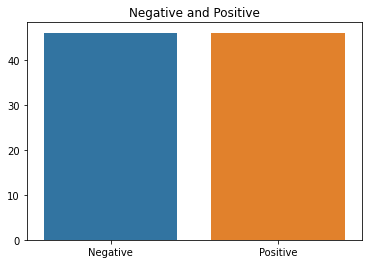

In [23]:
#visualize numbers of image files in each directories
sns.barplot(x=['Negative','Positive'], y=[len(path_Negative), len(path_Positive)])
plt.title('Negative and Positive')

based on bar chart above, we can see that the images data between two label is evenly distributed and NOT imbalance

In [24]:
#check how many classes in dataset
data_dir = pathlib.Path("/content/drive/My Drive/concrete")
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

['Negative' 'Positive' 'Testing_Data' 'checkpoint'
 'modelcheck.data-00000-of-00001' 'modelcheck.index']


In [25]:
#view image
import matplotlib.image as mpimg
import random 

#create function to show random image from google drive folder randomly 
def view_random_image(target_dir, target_class):
  target_folder = target_dir+target_class

  # Ambil sembarang gambar
  random_image = random.sample(os.listdir(target_folder), 1)

  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}")

  return img

Image shape: (227, 227, 3)


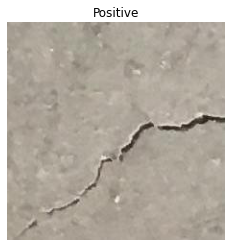

In [26]:
#shows image randomly from positive class
img = view_random_image(target_dir="/content/drive/My Drive/concrete/",
                        target_class="Positive")

brief information :

* the image has dimension 227 x 227 x 3 
  - image size 227 x 227 with 3 as rgb indicator
* positive image shows concrete with crack on it
* negative image shows concrete without any crack on it


##### Checking specified images

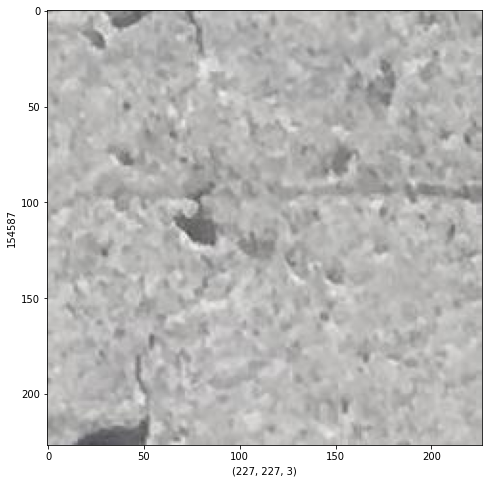

In [27]:
#check image in row 4
simple_vision(all_df["FilePath"][4])

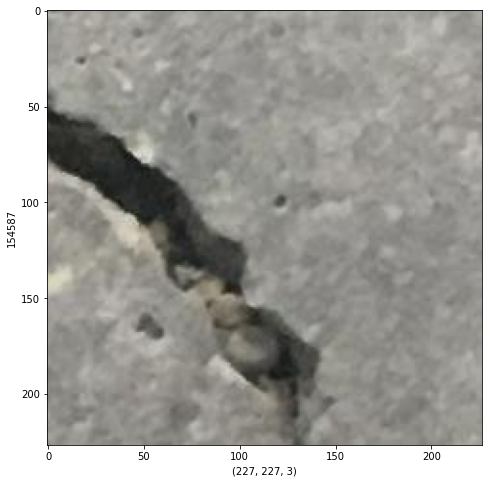

In [28]:
#check image in row two
simple_vision(all_df["FilePath"][2])

#### Crack Surface (Positive)

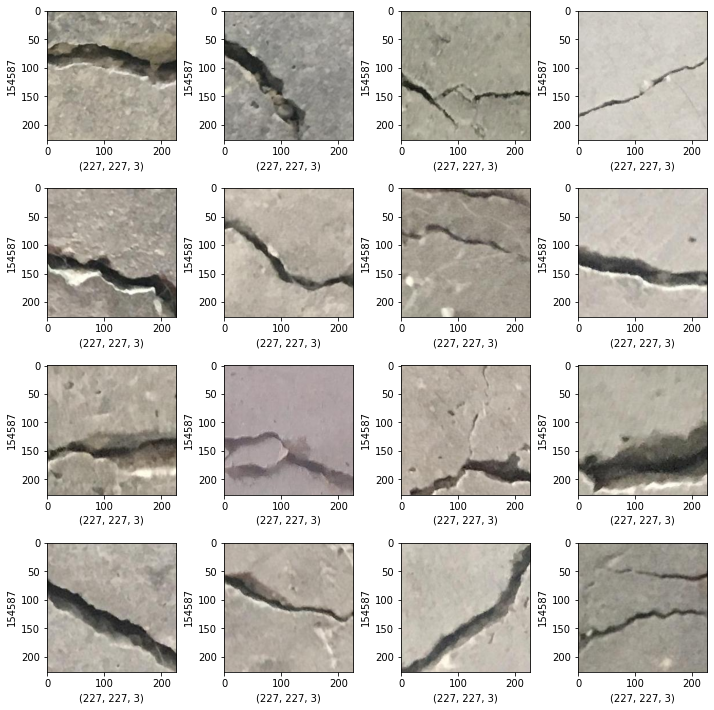

In [29]:
#set figure size and subplots dimension
figure,axis = plt.subplots(4,4,figsize=(10,10))

#create looping to iterate positive image
for indexing,operations in enumerate(axis.flat):
    
    Reading_Img = cv2.imread(Positive_Surface["FilePath"][indexing])
    Reading_Img = cv2.cvtColor(Reading_Img,cv2.COLOR_BGR2RGB)
    
    operations.set_xlabel(Reading_Img.shape)
    operations.set_ylabel(Reading_Img.size)
    operations.imshow(Reading_Img)
    
plt.tight_layout()
plt.show()

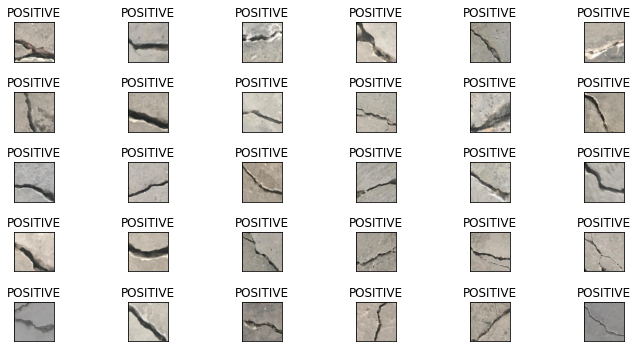

In [30]:
# show the positive image with label above it using subplots
# this subplots size is 5 x 6 with each image inside 10 x 5 space
fig, axes = plt.subplots(nrows=5, ncols=6,figsize=(10,5), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(positive_df.FilePath[i]))
    ax.set_title(positive_df.Label[i]) # set the label above the image
plt.tight_layout()
plt.show()

Canny Vision

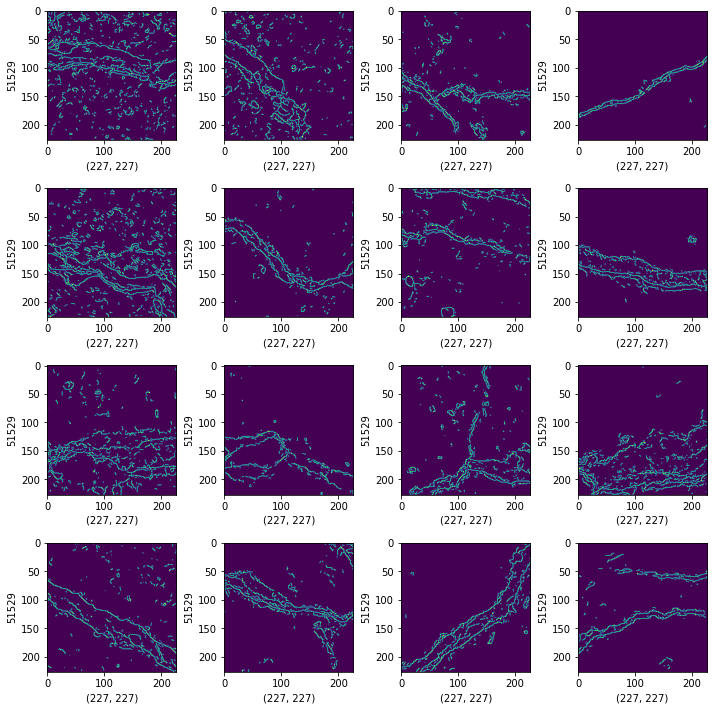

In [31]:
#set figure size and subplots dimension
figure,axis = plt.subplots(4,4,figsize=(10,10))

#iterate
for indexing,operations in enumerate(axis.flat):
    
    Reading_Img = cv2.imread(Positive_Surface["FilePath"][indexing])
    Reading_Img = cv2.cvtColor(Reading_Img,cv2.COLOR_BGR2RGB)
    
    Canny_Img = cv2.Canny(Reading_Img,90,100)
    
    operations.set_xlabel(Canny_Img.shape)
    operations.set_ylabel(Canny_Img.size)
    operations.imshow(Canny_Img)
    
plt.tight_layout()
plt.show()

we can see clear, there are lines of crack on the image either it's on the top, middle or bottom

Threshold Vision

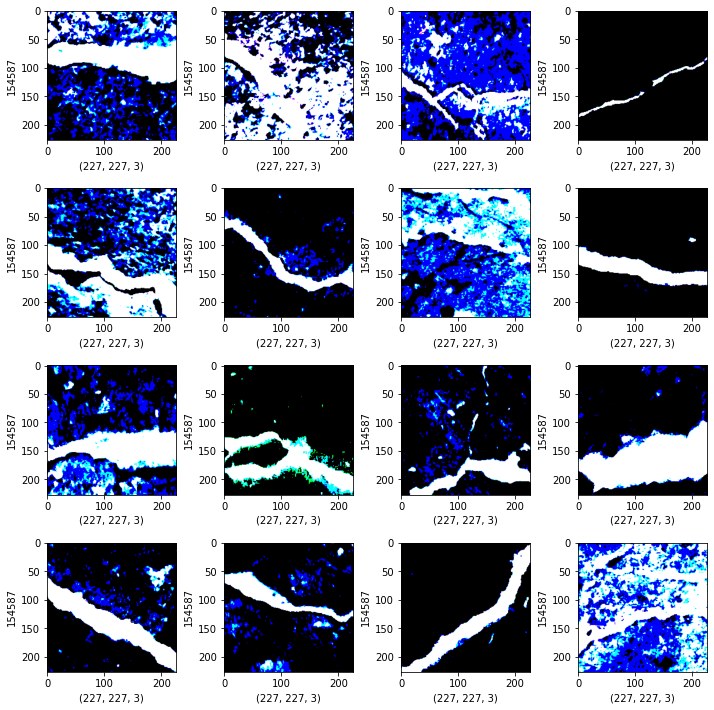

In [32]:
#show image with certain threshold 
figure,axis = plt.subplots(4,4,figsize=(10,10))

for indexing,operations in enumerate(axis.flat):
    
    Reading_Img = cv2.imread(Positive_Surface["FilePath"][indexing])
    Reading_Img = cv2.cvtColor(Reading_Img,cv2.COLOR_BGR2RGB)
    
    _,Threshold_Img = cv2.threshold(Reading_Img,150,255,cv2.THRESH_BINARY_INV)
    
    operations.set_xlabel(Threshold_Img.shape)
    operations.set_ylabel(Threshold_Img.size)
    operations.imshow(Threshold_Img)
    
plt.tight_layout()
plt.show()

#### No Crack Surface (Negative)


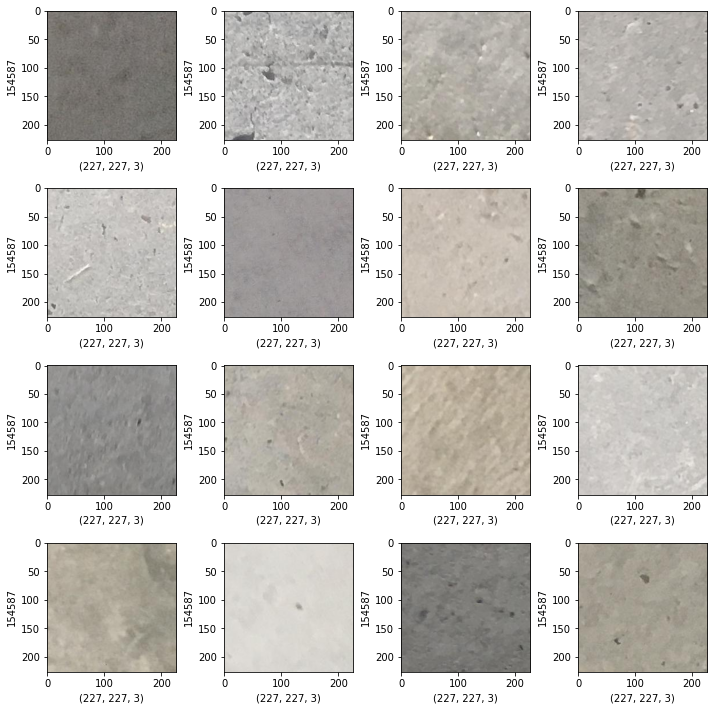

In [33]:
#visualize negative labeled images and the size of each image
figure,axis = plt.subplots(4,4,figsize=(10,10))

for indexing,operations in enumerate(axis.flat):
    
    Reading_Img = cv2.imread(Negative_Surface["FilePath"][indexing])
    Reading_Img = cv2.cvtColor(Reading_Img,cv2.COLOR_BGR2RGB)
    
    operations.set_xlabel(Reading_Img.shape)
    operations.set_ylabel(Reading_Img.size)
    operations.imshow(Reading_Img)
    
plt.tight_layout()
plt.show()

the image seems to be in the same size which is 227x227x3, 3 means rgb the images is colored not only black and white like grayscale

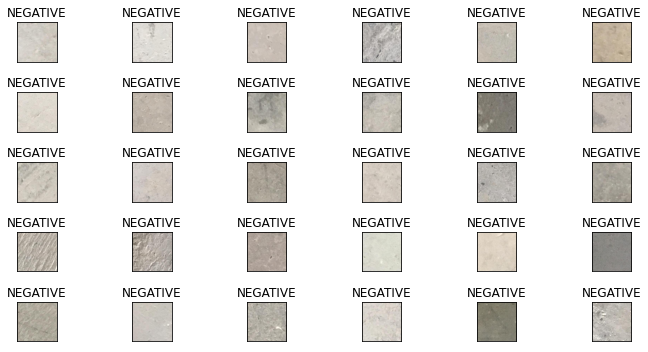

In [34]:
#show the image again to check if any crack image is shown
fig, axes = plt.subplots(nrows=5, ncols=6,figsize=(10,5), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(negative_df.FilePath[i]))
    ax.set_title(negative_df.Label[i])
plt.tight_layout()
plt.show()

Canny Vision

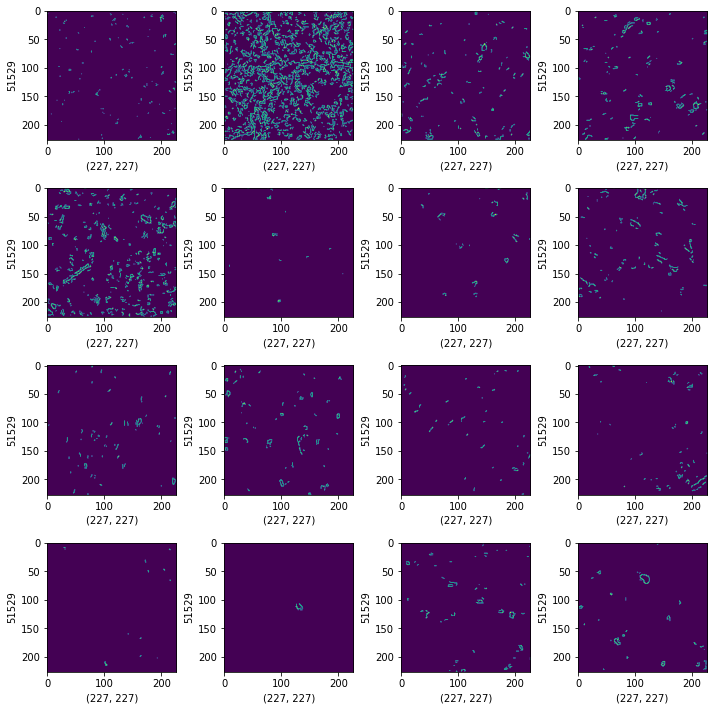

In [36]:
#visualizer the image data using canny 
figure,axis = plt.subplots(4,4,figsize=(10,10))

for indexing,operations in enumerate(axis.flat):
    
    Reading_Img = cv2.imread(Negative_Surface["FilePath"][indexing])
    Reading_Img = cv2.cvtColor(Reading_Img,cv2.COLOR_BGR2RGB)
    
    Canny_Img = cv2.Canny(Reading_Img,90,100)
    
    operations.set_xlabel(Canny_Img.shape)
    operations.set_ylabel(Canny_Img.size)
    operations.imshow(Canny_Img)
    
plt.tight_layout()
plt.show()

we can see clear, there are no lines of crack on the image either it's on the top, middle or bottom like previous cracked images before

Threshold Vision

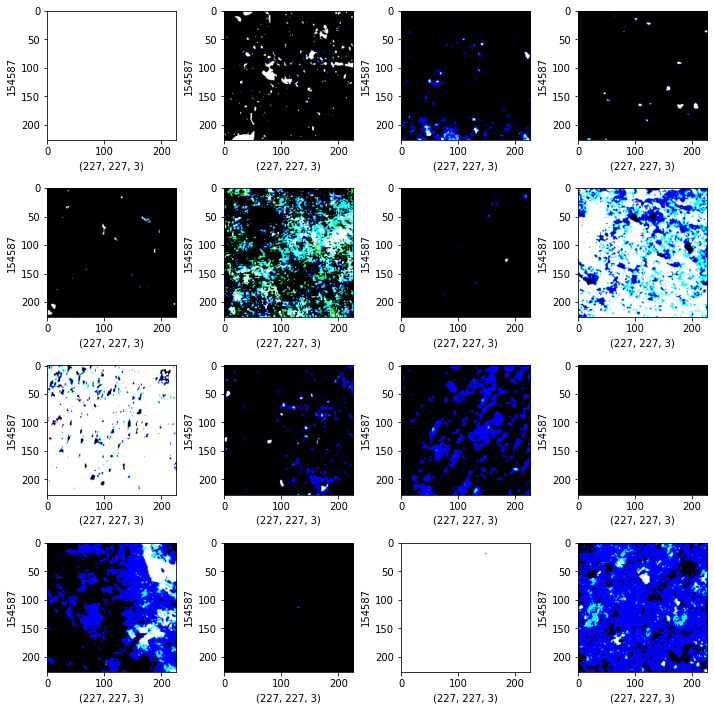

In [37]:
#showing images data using threshold 
figure,axis = plt.subplots(4,4,figsize=(10,10))

for indexing,operations in enumerate(axis.flat):
    
    Reading_Img = cv2.imread(Negative_Surface["FilePath"][indexing])
    Reading_Img = cv2.cvtColor(Reading_Img,cv2.COLOR_BGR2RGB)
    
    _,Threshold_Img = cv2.threshold(Reading_Img,150,255,cv2.THRESH_BINARY_INV)
    
    operations.set_xlabel(Threshold_Img.shape)
    operations.set_ylabel(Threshold_Img.size)
    operations.imshow(Threshold_Img)
    
plt.tight_layout()
plt.show()

as you can see from visualization above, that positive image only shown image with a big crack on it and none with negative image

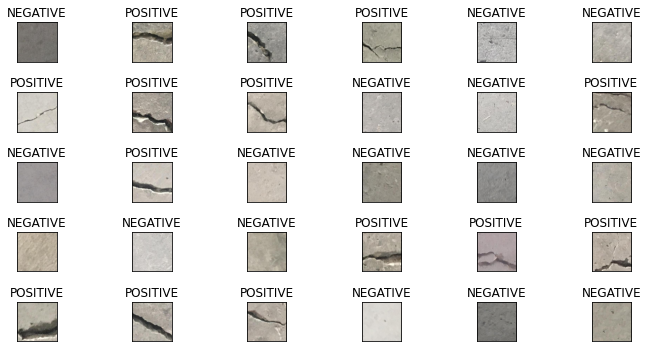

In [35]:
#shown the image one more time, to make sure the label match the images or not
fig, axes = plt.subplots(nrows=5, ncols=6,figsize=(10,5), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(all_df.FilePath[i]))
    ax.set_title(all_df.Label[i])
plt.tight_layout()
plt.show()

# Data Preprocessing

### Train & Test Split

after performing the above step we will store the generated value in a variable. here we are provide label as positive and negative because later we are going to use tensor flow from data frame there it will be expecting string value instead of int so to avoid error over there we are using. in the above (data loading section) piece of code we are concating the positive and negative data frame one over other and as we can see there is two error all positive class is displayed first and later it is displaying negative class also there is error in the index part so to address those issue we have to shuffle the data set and also we have to rearrange the entire data set after concatenation and we have to reset the index and we have to put drop=True to avoid creation of new column

once we are ready with our positive and negative data set next step is we have to spilt our data into traing and testing phase and we are considering only 10k data set for building our model and we have split data into 70-30 ratio and we are shuffling it

In [38]:
#i use Xtrain Xtest for familiarity purpose so i can understand the code further
#i use train_test_split to split all_df dataset with 70% train 30% test and shuffling it too
Xtrain, Xtest = train_test_split(all_df,train_size=0.7,shuffle=True,random_state=42)

In [39]:
#check train data shape
Xtrain.shape

(7000, 2)

In [40]:
#check test data shape
Xtest.shape

(3000, 2)

### Preprocess Data using ImageDataGenerator

further details :

https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

In [41]:
# for preprocessing steps i use ImageDataGenerator as one of the preprocessing process and ass pipeline 
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
    validation_split=0.2
)

test_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

In [42]:
#try to show data train
Xtrain

,FilePath,Label
9069,Positive/02163.jpg,POSITIVE
2603,Negative/04666.jpg,NEGATIVE
7738,Positive/04951.jpg,POSITIVE
1579,Positive/02379.jpg,POSITIVE
5058,Positive/04207.jpg,POSITIVE
...,...,...
5734,Positive/02934.jpg,POSITIVE
5191,Negative/04214.jpg,NEGATIVE
5390,Negative/03988.jpg,NEGATIVE
860,Positive/00489.jpg,POSITIVE


as we can see the train data have 7000 rows of data which exactly 70% we defined above

In [43]:
# here we want to read the data from the data frame and add validation data
# on the val_data parameter we can see subset = validation and subset = training for train data 
# all that to make those two data different than each other since the all the parameter are basically the same
train_data = train_gen.flow_from_dataframe(
    Xtrain,
    x_col='FilePath',
    y_col='Label',
    target_size=(227, 227),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_data = train_gen.flow_from_dataframe(
    Xtrain,
    x_col='FilePath',
    y_col='Label',
    target_size=(227, 227),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation' #subset is different
)

test_data = train_gen.flow_from_dataframe(
    Xtest,
    x_col='FilePath',
    y_col='Label',
    target_size=(227, 227),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=False,
    seed=42
)

Found 5600 validated image filenames belonging to 2 classes.
Found 1400 validated image filenames belonging to 2 classes.
Found 3000 validated image filenames belonging to 2 classes.


we can see here, the validation data is split into 20% 1400 data of 7000 data which belong to train data 

In [44]:
#check what classes is in the data
train_data.class_indices

{'NEGATIVE': 0, 'POSITIVE': 1}

In [45]:
#overall check for each dataset (train, validaton, test)
print("TRAIN DATA : ")
print(train_data.class_indices)
print(train_data.classes[0:5])
print(train_data.image_shape)
print("---"*20)
print("VALIDATION DATA : ")
print(val_data.class_indices)
print(val_data.classes[0:5])
print(val_data.image_shape)
print("---"*20)
print("TEST DATA : ")
print(test_data.class_indices)
print(test_data.classes[0:5])
print(test_data.image_shape)

TRAIN DATA : 
{'NEGATIVE': 0, 'POSITIVE': 1}
[0, 0, 1, 1, 0]
(227, 227, 3)
------------------------------------------------------------
VALIDATION DATA : 
{'NEGATIVE': 0, 'POSITIVE': 1}
[1, 0, 1, 1, 1]
(227, 227, 3)
------------------------------------------------------------
TEST DATA : 
{'NEGATIVE': 0, 'POSITIVE': 1}
[0, 1, 0, 0, 1]
(227, 227, 3)


In [46]:
print(train_data.image_shape[0],train_data.image_shape[1],train_data.image_shape[2])

227 227 3


# Model Definition, Training, Evaluation 

We will use 3 types of model here, to get more insight and different results and compare it to get the best result possible, the models are :     
1. normal cnn model
2. vgg16 pre-trained model
3. resnet50 pre-trained model

the purposes of training those model is to get the better model to detect crack surface images

Define variables for callbacks

In [47]:
#define earlystopper and model checkpoints for callbacks
Early_Stopper = tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=3, restore_best_weights=True) #this variable defined for early stopper in callbacks when you train the model in order to speed up the training steps
Checkpoint_Model = tf.keras.callbacks.ModelCheckpoint(monitor="val_accuracy",
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      filepath="./modelcheck")

Define compile parameters

In [48]:
#define compile parameters
compile_optimizer = "adam" #this compile optimizer will be used in model compile
compile_loss = "binary_crossentropy" #this compile loss type will be used in model compile process
input_dim = (train_data.image_shape[0],train_data.image_shape[1],train_data.image_shape[2]) #this variable gives you the image size for input_shape later
class_dim = 1

## Define Base Model 

here i use 16 and 32 filters with maxpooling2D using relu as activation function and the output layer should be sigmoid 

In [49]:
# create function for base_model training
base_model = Sequential()
base_model.add(Conv2D(16,(3,3),activation="relu",input_shape=input_dim))
base_model.add(MaxPooling2D((2,2),strides=2))
base_model.add(Conv2D(32,(3,3),activation="relu"))
base_model.add(MaxPooling2D((2,2),strides=2))
base_model.add(GlobalAveragePooling2D())
base_model.add(Flatten())
base_model.add(Dense(1,activation="sigmoid"))

### Base Model Summary

In [50]:
#print model architecture
print(base_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 225, 225, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 110, 110, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 55, 55, 32)       0         
 2D)                                                             
                                                                 
 global_average_pooling2d (G  (None, 32)               0         
 lobalAveragePooling2D)                                          
                                                        

### Compile Base Model

In [51]:
#compile base_model
base_model.compile(loss=compile_loss,
                   optimizer=compile_optimizer,
                   metrics=['accuracy'])

### Train Base Model

Now it's time to train the baseline model for crack surface detection


In [52]:
#train with validation data = val_data with epoch=50
#please wait since the model training might take a while to finish
history_base = base_model.fit(
               train_data,
               validation_data=val_data,
               verbose =1, 
               epochs = 50 #to degine amount of epochs
               #callbacks=[Early_Stopper]
       )

Epoch 1/50
175/175 [==============================] - 510s 3s/step - loss: 0.6811 - accuracy: 0.5593 - val_loss: 0.6517 - val_accuracy: 0.6229
Epoch 2/50
175/175 [==============================] - 21s 118ms/step - loss: 0.6272 - accuracy: 0.6666 - val_loss: 0.5853 - val_accuracy: 0.7664
Epoch 3/50
175/175 [==============================] - 21s 118ms/step - loss: 0.5419 - accuracy: 0.7959 - val_loss: 0.5021 - val_accuracy: 0.8093
Epoch 4/50
175/175 [==============================] - 20s 117ms/step - loss: 0.4376 - accuracy: 0.8786 - val_loss: 0.4056 - val_accuracy: 0.9179
Epoch 5/50
175/175 [==============================] - 21s 119ms/step - loss: 0.3436 - accuracy: 0.9105 - val_loss: 0.3461 - val_accuracy: 0.9164
Epoch 6/50
175/175 [==============================] - 21s 120ms/step - loss: 0.2911 - accuracy: 0.9175 - val_loss: 0.3149 - val_accuracy: 0.8943
Epoch 7/50
175/175 [==============================] - 20s 117ms/step - loss: 0.2723 - accuracy: 0.9284 - val_loss: 0.2791 - val_accu

* in this section i will make input layer, hidden layer and output layer for baseline model
* here i didn't use dropout yet and purely want to check the baseline model only using globalaveragepoolind2d as additional 

#### plot curves functions

i created functions for plotting loss and accuracy for the model

In [54]:
def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

In [55]:
def plot_loss_curves_other(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['acc']
  val_accuracy = history.history['val_acc']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

### Base Model Evaluation

Let's Display the results and observe :

In [53]:
#here i visualize actual loss and validation loss
fig = px.line(
    history_base.history,
    y=['loss', 'val_loss'],
    labels={'index': "Epoch", 'value': "Loss"},
    title="Training and Validation Loss Over Time"
)

fig.show()

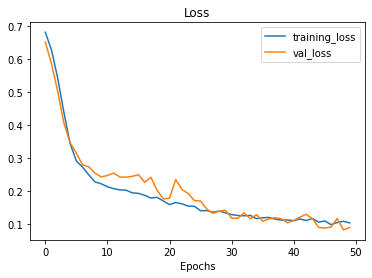

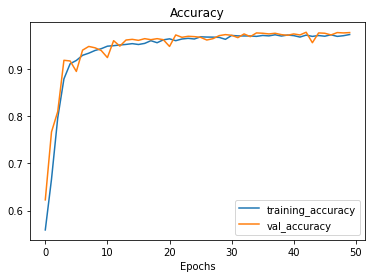

In [56]:
#define loss and accuracy graphs
plot_loss_curves(history_base)

obeserve:
1. we can see that the model is not overfit but still need to reduce the exploding gradient 
2. for accuracy is above 90% which is great 
3. for loss if we add more epoch the loss might go even lower

In [57]:
#create function for evaluating model using confusion matrix and classification report 
def evaluate_model(model, test_data):
    
    results = model.evaluate(test_data, verbose=0)
    loss = results[0]
    acc = results[1]
    
    print("    Test Loss: {:.5f}".format(loss))
    print("Test Accuracy: {:.2f}%".format(acc * 100))
    
    y_pred = np.squeeze((model.predict(test_data) >= 0.5).astype(np.int))
    cm = confusion_matrix(test_data.labels, y_pred)
    clr = classification_report(test_data.labels, y_pred, target_names=["NEGATIVE", "POSITIVE"])
    
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
    plt.xticks(ticks=np.arange(2) + 0.5, labels=["NEGATIVE", "POSITIVE"])
    plt.yticks(ticks=np.arange(2) + 0.5, labels=["NEGATIVE", "POSITIVE"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()
    
    print("Classification Report:\n----------------------\n", clr)

In [58]:
#predicts using test data
preds = base_model.predict(test_data)

In [59]:
preds

array([[0.03700195],
       [0.99817073],
       [0.0180341 ],
       ...,
       [1.        ],
       [0.9999566 ],
       [1.        ]], dtype=float32)

    Test Loss: 0.11725
Test Accuracy: 97.70%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning:

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



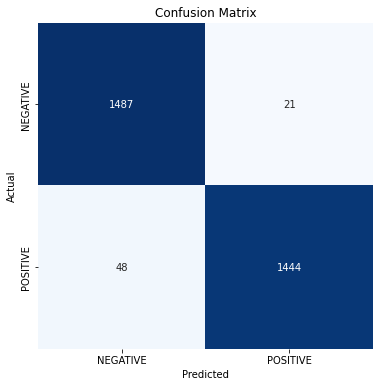

Classification Report:
----------------------
               precision    recall  f1-score   support

    NEGATIVE       0.97      0.99      0.98      1508
    POSITIVE       0.99      0.97      0.98      1492

    accuracy                           0.98      3000
   macro avg       0.98      0.98      0.98      3000
weighted avg       0.98      0.98      0.98      3000



In [60]:
evaluate_model(base_model, test_data)

* the base model returns great accuracy which is 98% with great recall and precision percentage
* i assume that happens because i use a lot of data for each label so the model can learn enough to identified the image


# Transfer Learning / Fine Tuning

### Functions

In [61]:
#import library 
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.callbacks import Callback,EarlyStopping

## VGG16

In [62]:
#import VGG16 pretrained model
from tensorflow.keras.applications.vgg16 import VGG16

#define model and parameters
base_model2 = VGG16(input_shape = (227, 227, 3), # Shape of our images
include_top = False, # Leave out the last fully connected layer
weights = 'imagenet')

58900480/58889256 [==============================] - 0s 0us/step


In [63]:
for layer in base_model2.layers:
    layer.trainable = False

#### Define Model

In [64]:
# Flatten the output layer to 1 dimension
x = tf.keras.layers.Flatten()(base_model2.output)

# Add a fully connected layer with 512 hidden units and ReLU activation
x = tf.keras.layers.Dense(512, activation='relu')(x)

# Add a final sigmoid layer with 1 node for classification output
x = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model2 = tf.keras.models.Model(base_model2.input, x)

model2.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss = 'binary_crossentropy',metrics = ['acc'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



In [98]:
print(model2.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 227, 227, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 227, 227, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 227, 227, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 113, 113, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 113, 113, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 113, 113, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

### Train Pretrained Base Model

Now it's time to train the vgg16 baseline model for crack surface detection

In [65]:
#train the model
vgghist = model2.fit(train_data, validation_data = val_data, steps_per_epoch = 100, epochs = 10)

Epoch 1/10
100/100 [==============================] - 17s 151ms/step - loss: 0.1486 - acc: 0.9572 - val_loss: 0.0228 - val_acc: 0.9921
Epoch 2/10
100/100 [==============================] - 15s 151ms/step - loss: 0.0370 - acc: 0.9869 - val_loss: 0.1085 - val_acc: 0.9657
Epoch 3/10
100/100 [==============================] - 16s 163ms/step - loss: 0.0363 - acc: 0.9891 - val_loss: 0.0252 - val_acc: 0.9921
Epoch 4/10
100/100 [==============================] - 14s 142ms/step - loss: 0.0360 - acc: 0.9872 - val_loss: 0.0149 - val_acc: 0.9943
Epoch 5/10
100/100 [==============================] - 15s 153ms/step - loss: 0.0251 - acc: 0.9900 - val_loss: 0.0067 - val_acc: 0.9979
Epoch 6/10
100/100 [==============================] - 17s 170ms/step - loss: 0.0183 - acc: 0.9950 - val_loss: 0.0214 - val_acc: 0.9929
Epoch 7/10
100/100 [==============================] - 16s 158ms/step - loss: 0.0152 - acc: 0.9934 - val_loss: 0.0527 - val_acc: 0.9864
Epoch 8/10
100/100 [==============================] - 1

#### Evaluate VGG16 baseline model

Let's Display the results and observe :

In [66]:
#visualize loss 
fig = px.line(
    vgghist.history,
    y=['loss', 'val_loss'],
    labels={'index': "Epoch", 'value': "Loss"},
    title="Training and Validation Loss Over Time"
)

fig.show()

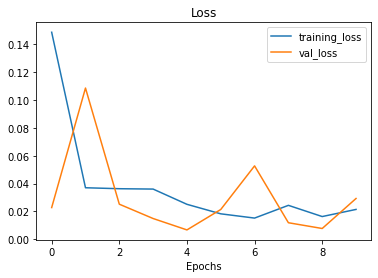

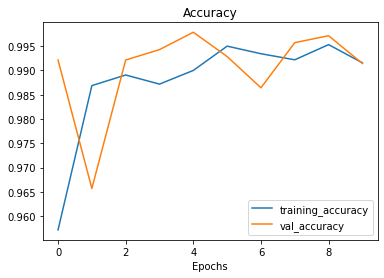

In [67]:
#visualize loss and accuracy
plot_loss_curves_other(vgghist)

* the model is actively learning, as we can see that validation loss is below actual loss which mean the model train more than the actual data
* the model seems to be goodly/decently fit


    Test Loss: 0.03967
Test Accuracy: 98.90%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning:

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



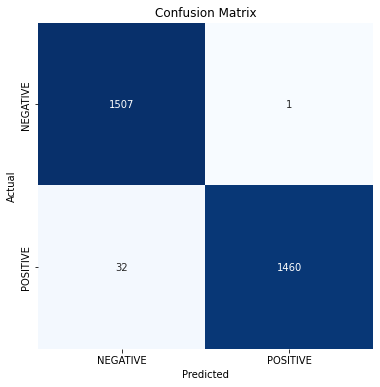

Classification Report:
----------------------
               precision    recall  f1-score   support

    NEGATIVE       0.98      1.00      0.99      1508
    POSITIVE       1.00      0.98      0.99      1492

    accuracy                           0.99      3000
   macro avg       0.99      0.99      0.99      3000
weighted avg       0.99      0.99      0.99      3000



In [68]:
evaluate_model(model2, test_data)

* the model gives great accuracy which almost hit 100% with great recall and precision
* base line model with pretrained model gives better result than the model without pretrained model, but i will improve on model improvement section

### ResNet50


#### Define ResNet50 Baseline Model

In [69]:
#import resnet library
from tensorflow.keras.applications import ResNet50

#define resnet base model using 227,227,3 shape the same as actual image dataset
base_model_res = ResNet50(input_shape=(227, 227,3), include_top=False, weights="imagenet")

94781440/94765736 [==============================] - 1s 0us/step


In [70]:
for layer in base_model_res.layers:
    layer.trainable = False

In [71]:
#define model and filters and output layer
base_modelres = Sequential()
base_modelres.add(ResNet50(include_top=False, weights='imagenet', pooling='max'))
base_modelres.add(Dense(1, activation='sigmoid'))

In [99]:
print(base_modelres.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_3 (Dense)             (None, 1)                 2049      
                                                                 
Total params: 23,589,761
Trainable params: 23,536,641
Non-trainable params: 53,120
_________________________________________________________________
None


#### Train Resnet Model


In [72]:
#compile model
base_modelres.compile(optimizer = tf.keras.optimizers.SGD(learning_rate=0.0001), loss = 'binary_crossentropy', metrics = ['accuracy'])

Now it's time to train the resnet50 baseline model for crack surface detection

In [73]:
#train model
resnet_history = base_modelres.fit(train_data, validation_data = val_data, steps_per_epoch = 100, epochs = 10)

Epoch 1/10
100/100 [==============================] - 32s 254ms/step - loss: 0.8782 - accuracy: 0.8034 - val_loss: 1.3444 - val_accuracy: 0.4736
Epoch 2/10
100/100 [==============================] - 25s 249ms/step - loss: 0.1491 - accuracy: 0.9456 - val_loss: 4.9819 - val_accuracy: 0.4743
Epoch 3/10
100/100 [==============================] - 24s 240ms/step - loss: 0.0929 - accuracy: 0.9719 - val_loss: 2.3600 - val_accuracy: 0.4707
Epoch 4/10
100/100 [==============================] - 24s 241ms/step - loss: 0.0588 - accuracy: 0.9769 - val_loss: 6.1172 - val_accuracy: 0.4743
Epoch 5/10
100/100 [==============================] - 25s 252ms/step - loss: 0.0404 - accuracy: 0.9847 - val_loss: 5.4877 - val_accuracy: 0.4707
Epoch 6/10
100/100 [==============================] - 25s 249ms/step - loss: 0.0376 - accuracy: 0.9875 - val_loss: 2.7749 - val_accuracy: 0.4564
Epoch 7/10
100/100 [==============================] - 24s 241ms/step - loss: 0.0226 - accuracy: 0.9947 - val_loss: 1.4774 - val_ac

#### Evaluate ResNet50 Baseline Model

Let's Display the results and observe :

In [74]:
#visualize loss 
fig = px.line(
    resnet_history.history,
    y=['loss', 'val_loss'],
    labels={'index': "Epoch", 'value': "Loss"},
    title="Training and Validation Loss Over Time"
)

fig.show()

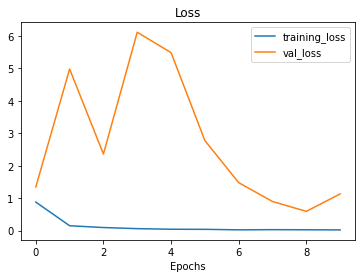

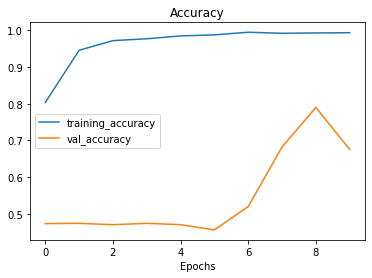

In [96]:
plot_loss_curves(resnet_history)

    Test Loss: 1.12442
Test Accuracy: 68.57%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning:

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



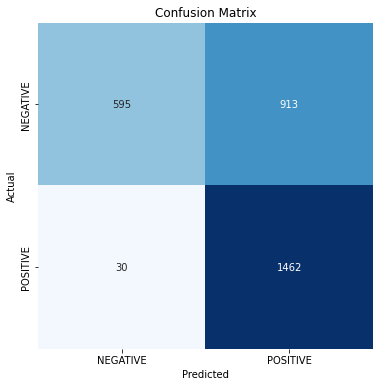

Classification Report:
----------------------
               precision    recall  f1-score   support

    NEGATIVE       0.95      0.39      0.56      1508
    POSITIVE       0.62      0.98      0.76      1492

    accuracy                           0.69      3000
   macro avg       0.78      0.69      0.66      3000
weighted avg       0.78      0.69      0.66      3000



In [75]:
evaluate_model(base_modelres, test_data)

* Based on models training above, i will use model with vgg16 because it gives result with the lowest loss and highest accuracy.
* for resnet50 it gives you good accuracy but the model is kind of overfitting

Below i will use the model and try to put more filters and dropout layers

# Model Improvements

Here, based on the results above, i decided to improve vgg16 model with baseline model without pretrained model to determine which model best for detecting surface crack

In [76]:
#define vgg16 model
vgg1 = VGG16(input_shape = (227, 227, 3), # Shape of our images
include_top = False, # Leave out the last fully connected layer
weights = 'imagenet')

In [77]:
#see the arhitecture
vgg1.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 227, 227, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 227, 227, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 227, 227, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 113, 113, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 113, 113, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 113, 113, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [78]:
for layer in vgg1.layers:
    layer.trainable=False

below i'm adding droput to the model 

In [79]:
# Flatten the output layer to 1 dimension
x = tf.keras.layers.Flatten()(vgg1.output)

# Add a fully connected layer with 512 hidden units and ReLU activation
x = tf.keras.layers.Dense(512, activation='relu')(x)
# Add a dropout rate of 0.5
x = tf.keras.layers.Dropout(0.5)(x)

# Add a final sigmoid layer with 1 node for classification output
x = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model3 = tf.keras.models.Model(vgg1.input, x)

### Compile Model

after using flatten(), the model acrhitecture is minimize into 1 dimension model

In [80]:
model3.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss = 'binary_crossentropy',metrics = ['acc'])
model3.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 227, 227, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 227, 227, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 227, 227, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 113, 113, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 113, 113, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 113, 113, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

### Model Training

Now it's time to train the vgg16 improved model for crack surface detection

In [81]:
#training vgg16 model
vgghistory = model3.fit(train_data, validation_data = val_data, epochs = 50)

Epoch 1/50
175/175 [==============================] - 23s 125ms/step - loss: 0.1018 - acc: 0.9657 - val_loss: 0.0152 - val_acc: 0.9943
Epoch 2/50
175/175 [==============================] - 24s 139ms/step - loss: 0.0380 - acc: 0.9879 - val_loss: 0.0287 - val_acc: 0.9914
Epoch 3/50
175/175 [==============================] - 24s 136ms/step - loss: 0.0329 - acc: 0.9896 - val_loss: 0.0097 - val_acc: 0.9957
Epoch 4/50
175/175 [==============================] - 23s 133ms/step - loss: 0.0259 - acc: 0.9918 - val_loss: 0.0234 - val_acc: 0.9929
Epoch 5/50
175/175 [==============================] - 26s 146ms/step - loss: 0.0245 - acc: 0.9920 - val_loss: 0.0433 - val_acc: 0.9893
Epoch 6/50
175/175 [==============================] - 25s 143ms/step - loss: 0.0190 - acc: 0.9943 - val_loss: 0.0074 - val_acc: 0.9971
Epoch 7/50
175/175 [==============================] - 22s 123ms/step - loss: 0.0173 - acc: 0.9943 - val_loss: 0.0140 - val_acc: 0.9936
Epoch 8/50
175/175 [==============================] - 2

#### Evaluate VGG16 Model

Let's Display the results and observe :

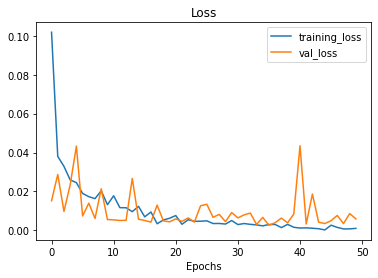

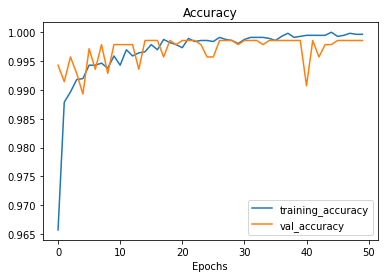

In [82]:
# plot loss and accuracy 
plot_loss_curves_other(vgghistory)

    Test Loss: 0.02380
Test Accuracy: 99.73%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning:

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



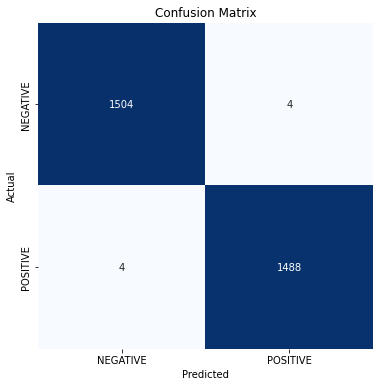

Classification Report:
----------------------
               precision    recall  f1-score   support

    NEGATIVE       1.00      1.00      1.00      1508
    POSITIVE       1.00      1.00      1.00      1492

    accuracy                           1.00      3000
   macro avg       1.00      1.00      1.00      3000
weighted avg       1.00      1.00      1.00      3000



In [97]:
#see confusion matrix and classification report with accuracy
evaluate_model(model3, test_data)

# Model Improvement Without pretrained model

#### Define Model

In [101]:
#define model with dropout and batchnormalization
# since good dropout rate is between 0.2 to 0.5 i'll use the lowest range
model1 = Sequential()

model1.add(Conv2D(16,(3,3),activation="relu",input_shape=input_dim))
model1.add(BatchNormalization())
model1.add(MaxPooling2D((2,2),strides=2))

model1.add(Conv2D(32,(3,3),activation="relu",padding="same"))
model1.add(Dropout(0.2))
model1.add(MaxPooling2D((2,2),strides=2))

model1.add(Conv2D(64,(3,3),activation="relu",padding="same"))
model1.add(Dropout(0.2))
model1.add(MaxPooling2D((2,2),strides=2))

model1.add(Conv2D(128,(3,3),activation="relu",padding="same"))
model1.add(Dropout(0.2))
model1.add(MaxPooling2D((2,2),strides=2))
#model1.add(GlobalAveragePooling2D())
model1.add(Flatten())
model1.add(Dense(256,activation="relu"))
model1.add(Dense(1,activation="sigmoid"))

In [102]:
#because there are only 2 classes for loss i will use binary_crossentropy to compile the model
model1.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [103]:
#show model architecture
print(model1.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 225, 225, 16)      448       
                                                                 
 batch_normalization_1 (Batc  (None, 225, 225, 16)     64        
 hNormalization)                                                 
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 112, 112, 16)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 dropout_4 (Dropout)         (None, 112, 112, 32)      0         
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 56, 56, 32)      

#### Train Model

Now it's time to train the normal cnn improved model for crack surface detection 

In [104]:
#train the model with callbacks to avoid waiting for so long
history2 = model1.fit(
    train_data,
    validation_data=val_data,
    epochs=100,
    verbose=1,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

Epoch 1/100
175/175 [==============================] - 22s 119ms/step - loss: 0.1750 - accuracy: 0.9450 - val_loss: 1.9738 - val_accuracy: 0.5257
Epoch 2/100
175/175 [==============================] - 21s 117ms/step - loss: 0.0446 - accuracy: 0.9854 - val_loss: 0.5791 - val_accuracy: 0.7307
Epoch 3/100
175/175 [==============================] - 21s 119ms/step - loss: 0.0176 - accuracy: 0.9955 - val_loss: 0.3434 - val_accuracy: 0.8800
Epoch 4/100
175/175 [==============================] - 21s 119ms/step - loss: 0.0182 - accuracy: 0.9957 - val_loss: 0.1397 - val_accuracy: 0.9507
Epoch 5/100
175/175 [==============================] - 21s 119ms/step - loss: 0.0179 - accuracy: 0.9946 - val_loss: 0.0334 - val_accuracy: 0.9857
Epoch 6/100
175/175 [==============================] - 21s 121ms/step - loss: 0.0019 - accuracy: 0.9993 - val_loss: 0.0063 - val_accuracy: 0.9979
Epoch 7/100
175/175 [==============================] - 21s 118ms/step - loss: 9.9048e-04 - accuracy: 0.9998 - val_loss: 0.00

#### Evaluate Model

Let's Display the results and observe :

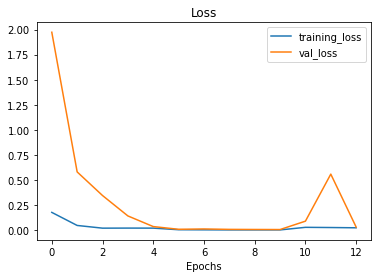

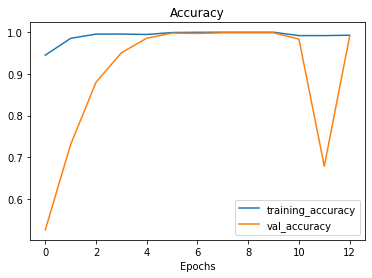

In [105]:
plot_loss_curves(history2)

    Test Loss: 0.00979
Test Accuracy: 99.80%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning:

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



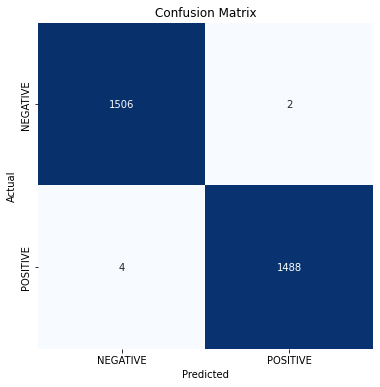

Classification Report:
----------------------
               precision    recall  f1-score   support

    NEGATIVE       1.00      1.00      1.00      1508
    POSITIVE       1.00      1.00      1.00      1492

    accuracy                           1.00      3000
   macro avg       1.00      1.00      1.00      3000
weighted avg       1.00      1.00      1.00      3000



In [106]:
evaluate_model(model1, test_data)

Observe :
* This Model is kind of underfit at first 
* after epoch = 15 the validation loss seems to be align to actual loss and made it kind of fit 
* we can see validation loss has exploding gradient a little bit not too exploeded soo i will probably use this model for deployment and model inference

# Save Model

i use model1 because it gives btter model accuracy, lower loss and less exploding gradient

In [88]:
#save the model on content folder and name it Crack_Detection_model.h5
model1.save('/content/Crack_Detection_model.h5')

# Model Inference

In [89]:
#upload image from testing_data folder
image = tf.keras.preprocessing.image.load_img("/content/drive/My Drive/concrete/Testing_Data/16400.jpg", target_size=(227, 227))

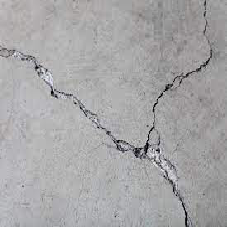

In [90]:
#show the image
image

In [91]:
# preprocess the image and change it to array
input_arr = tf.keras.preprocessing.image.img_to_array(image)
input_arr = np.array([input_arr]) 

In [92]:
#devide the image array by 255
input_arr = input_arr.astype('float32') / 255.

In [93]:
#predict with model1 using new_image
predictions = model1.predict(input_arr)

In [94]:
#here we assume predicitons below 0.5 are no crack and 0.5 or above considered to be cracked surface
print("Result:\n======================\n")
if(predictions[0]>=0.5):
    print("Crack Detected")
else:
    print("No Crack Detected")

Result:

Crack Detected


# Conclusion

Exploratory Data Analysis :     
1. The image dataset are all in the same size 227x227x3
2. each label has 5000 images 
3. there are 3 directories : positive, negative, testi_data
4. each images when it comes to label is already accurate
5. if the image data is visualized using canny it will show you the cracl line for each cracked surface image but for the normal one it's just tiny circle around the surface
6. using threshold we can see that crack surface gives you pattern like rivers with depth but image without crack gives you evenly distributed depth pattern

Model Results :
1. at first i tried to train the base model without any pretrained
2. second step i use pretrained model VGG16 and ResNet50 
3. third step i did model improvement by adding more filter and dropout for VGG16 and normal baseline Model
4. for baseline model vgg16 and normal baseline model gives great accuracy with low loss 
  - vgg16 gives 99.73% accuracy and slightly lower loss 
  - normal model 99.80% accuracy and slightly higher loss
5. i decided to choose the normal model because it gives you lower recall False Negative = 2 and less exploding gradient
